# Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import plotly.graph_objects as go

from scripts import Datax18, NARXx18



device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)
print(f"Using device: {device}")

Using device: mps


# Data preprocessing

Data Format Description in SN_ms_tot_V2.0.csv:

| Column(s) | Name | Description |
|-----------|------|-------------|
| 1-2 | Calendar Date | **Year** (YYYY) and **Month** (MM) in egorian calendar |
| 3 | Decimal Date | Date as fraction of year (YYYY.fff) |
| 4 | Sunspot Number | Monthly smoothed total sunspot count |
| 5 | Standard Deviation | Monthly mean std. dev. of input asurements |
| 6 | Sample Size | Number of observations used for monthly mean |
| 7 | Status | Data validation flag: |
|   |        | • 1 = Definitive (final) value |
|   |        | • 0 = Provisional value |



In [2]:
df_theoretical = pd.read_csv('data/theoretical_series.csv', sep=';')
df_theoretical

,decimal_date,T1,T2,T3,T4,T5
0,1964.290000,6.238113,1.358705,8.952250,20.055768,15.689878
1,1964.373000,6.552118,1.509507,9.384701,20.675201,14.810065
2,1964.456000,6.888593,1.682225,9.867576,21.396530,14.318844
3,1964.540000,7.252599,1.858949,10.374440,22.039826,14.351114
4,1964.624000,7.667502,2.059977,10.954735,22.754826,14.813335
...,...,...,...,...,...,...
849,2035.039667,69.618968,110.107073,28.882009,135.716777,146.994017
850,2035.123000,75.885278,114.582486,30.671043,138.589157,149.402212
851,2035.206333,82.070992,118.824089,32.538707,141.274664,151.558947
852,2035.289667,88.125722,122.809352,34.313209,143.648229,153.460878


In [3]:
df_ssn = pd.read_csv(
    'data/SN_ms_tot_V2.0.csv',
    sep=';',
    header=None,
    names=['Year', 'Month', 'Decimal Date', 'SSN', 'Std Dev', 'Obs', 'Def'],
)
print(df_ssn)
df_ssn = df_ssn[['Decimal Date', 'SSN']]

     Year  Month  Decimal Date   SSN  Std Dev   Obs  Def
0    1964      4      1964.290  18.6      2.9    30    1
1    1964      5      1964.373  16.0      2.7    31    1
2    1964      6      1964.456  15.0      2.6    30    1
3    1964      7      1964.540  15.2      2.7    31    1
4    1964      8      1964.624  15.1      2.6    31    1
..    ...    ...           ...   ...      ...   ...  ...
727  2024     11      2024.873  -1.0     -1.0   681    0
728  2024     12      2024.958  -1.0     -1.0   572    0
729  2025      1      2025.042  -1.0     -1.0   670    0
730  2025      2      2025.122  -1.0     -1.0   655    0
731  2025      3      2025.204  -1.0     -1.0  1011    0

[732 rows x 7 columns]


Match the decimal date in df_theoretical with the decimal date in df_ssn

In [4]:
df_ssn = df_ssn[df_ssn['Decimal Date'] >= df_theoretical['decimal_date'].iloc[0]]

df_ssn = df_ssn[df_ssn['SSN'].shift(1) != -1]
df_ssn

df_ssn = df_ssn.reset_index(drop=True)
df_ssn


,Decimal Date,SSN
0,1964.290,18.6
1,1964.373,16.0
2,1964.456,15.0
3,1964.540,15.2
4,1964.624,15.1
...,...,...
722,2024.455,152.7
723,2024.540,154.9
724,2024.624,156.7
725,2024.706,159.3


In [5]:
theoretical_series = df_theoretical['T1'].values
observed_series = df_ssn['SSN'].values

theoretical_series.shape, observed_series.shape

((854,), (727,))

In [6]:
prev_values = 4
horizon = 18
data = Datax18(theoretical_series, observed_series, prev_values, horizon)

In [85]:
print(data.X[0])
print(data.y[0])
print(data.X[-1])
print(data.y[-1])

print(data.X.shape)
print(data.y.shape)


tensor([ 6.2381,  6.5521,  6.8886,  7.2526,  7.6675,  8.1085,  8.5509,  9.0527,
         9.6095, 10.2175, 10.8941, 11.5831, 12.3269, 13.1797, 14.1111, 15.0880,
        16.2089, 17.3378, 18.6209, 20.0790, 21.6504, 23.3132, 18.6000, 16.0000,
        15.0000, 15.2000])
tensor(39.7000)
tensor([106.9758, 111.0381, 114.9452, 118.7616, 122.3247, 125.6474, 128.7271,
        131.6180, 134.3703, 136.9060, 139.2164, 141.3179, 143.2396, 144.9878,
        146.5429, 147.9763, 149.2225, 150.2702, 151.1274, 151.7974, 152.2834,
        152.6333, 113.3000, 117.8000, 121.1000, 122.9000])
tensor(-1.)
torch.Size([706, 26])
torch.Size([706])


In [86]:
train_data_X = data.X[:722 + 1 - (horizon - 1) - prev_values]
train_data_y = data.y[:722 + 1 - (horizon - 1) - prev_values]
train_data_X.shape, train_data_y.shape, data.X.shape, data.y.shape

(torch.Size([702, 26]),
 torch.Size([702]),
 torch.Size([706, 26]),
 torch.Size([706]))

In [87]:
test_data_X = data.X[722 + 1 - (horizon - 1) - prev_values: 722 + 1 - (horizon - 1) - prev_values + 4]
test_data_y = data.y[722 + 1 - (horizon - 1) - prev_values: 722 + 1 - (horizon - 1) - prev_values + 4]

In [88]:
test_data_X, test_data_y

(tensor([[ 93.6175,  98.2260, 102.6996, 106.9758, 111.0381, 114.9452, 118.7616,
          122.3247, 125.6474, 128.7271, 131.6180, 134.3703, 136.9060, 139.2164,
          141.3179, 143.2396, 144.9878, 146.5429, 147.9763, 149.2225, 150.2702,
          151.1274,  98.9000, 101.2000, 106.7000, 113.3000],
         [ 98.2260, 102.6996, 106.9758, 111.0381, 114.9452, 118.7616, 122.3247,
          125.6474, 128.7271, 131.6180, 134.3703, 136.9060, 139.2164, 141.3179,
          143.2396, 144.9878, 146.5429, 147.9763, 149.2225, 150.2702, 151.1274,
          151.7974, 101.2000, 106.7000, 113.3000, 117.8000],
         [102.6996, 106.9758, 111.0381, 114.9452, 118.7616, 122.3247, 125.6474,
          128.7271, 131.6180, 134.3703, 136.9060, 139.2164, 141.3179, 143.2396,
          144.9878, 146.5429, 147.9763, 149.2225, 150.2702, 151.1274, 151.7974,
          152.2834, 106.7000, 113.3000, 117.8000, 121.1000],
         [106.9758, 111.0381, 114.9452, 118.7616, 122.3247, 125.6474, 128.7271,
          131.618

In [9]:
path_to_models = 'weights_and_data/real_model/'

predictions = []

M = np.max(observed_series)
observed_series = observed_series / M
theoretical_series = theoretical_series / M

for horizon in range (1, 19):
    model = NARXx18(2 * 4 + horizon, [24], 1, M)
    model.load_state_dict(torch.load(
        os.path.join(path_to_models, f'model_weights_horizon{horizon}.pth'),
        map_location=torch.device('mps')
    ))
    data = Datax18(theoretical_series, observed_series, 4, horizon)
    test_data_X = data.X[722 + 1 - (horizon - 1) - 4: 722 + 1 - (horizon - 1) - 4 + 4]
    test_data_X = test_data_X.to(device)
    model = model.to(device)
    res = model(test_data_X).squeeze()
    res = res.cpu().detach().numpy()
    res = res * M
    predictions.append(res)
    
predictions = np.array(predictions)
    


In [30]:
predictions.T[0]

array([154.83944127, 153.68250803, 151.35409329, 150.70101828,
       145.721448  , 141.12357505, 141.69835602, 138.57538173,
       131.62545312, 131.94377947, 128.81411409, 136.79519184,
       139.70146934, 139.35010402, 138.37852219, 135.7698731 ,
       154.0778374 , 137.98595533])

In [32]:


import datetime

import datetime
from dateutil.relativedelta import relativedelta

start_month = 7
start_year = 2024  # Use full year here
start_date = datetime.datetime(start_year, start_month, 1) 
date = start_date + relativedelta(months=6)

# Создаем файлы CSV
for i in range(4):
    year, month = date.year, date.month
    file_name = f"R_{year}_{str(month).zfill(2)}.txt"
    with open(file_name, "w") as file:
        for j in range(18):
            file.write(f"{predictions.T[i][j]}\n")
    date += relativedelta(months=1)
    

In [52]:
observed_series 

array([ 0.0798626 ,  0.06869901,  0.06440532,  0.06526406,  0.06483469,
        0.06268785,  0.06139974,  0.06440532,  0.06955775,  0.07385144,
        0.07599828,  0.07900386,  0.0854444 ,  0.09102619,  0.0936024 ,
        0.09703736,  0.10218978,  0.10820094,  0.12194075,  0.13782739,
        0.15113783,  0.17045942,  0.19235723,  0.21124946,  0.22885359,
        0.24860455,  0.27221984,  0.30656934,  0.34478317,  0.3842851 ,
        0.41133534,  0.42679261,  0.44224989,  0.4559897 ,  0.47917561,
        0.50021468,  0.51438386,  0.53198798,  0.55560326,  0.57234865,
        0.57964792,  0.57921855,  0.57750107,  0.59081151,  0.61185058,
        0.62387291,  0.62559038,  0.6363246 ,  0.65178188,  0.65435809,
        0.64791756,  0.63933018,  0.63718334,  0.65049377,  0.66766853,
        0.67239158,  0.66981537,  0.66852726,  0.66595105,  0.65650494,
        0.64705882,  0.64577072,  0.64448261,  0.64362387,  0.64705882,
        0.64061829,  0.63288965,  0.63546587,  0.63761271,  0.64

In [54]:
theoretical_series.shape, observed_series.shape, predictions.shape

((854,), (727,), (18, 4))

In [55]:
theoretical_series, observed_series, predictions

(array([ 2.67845143e-02,  2.81327506e-02,  2.95774706e-02,  3.11404009e-02,
         3.29218616e-02,  3.48152611e-02,  3.67146967e-02,  3.88696303e-02,
         4.12601404e-02,  4.38708108e-02,  4.67758139e-02,  4.97340984e-02,
         5.29278605e-02,  5.65894882e-02,  6.05888196e-02,  6.47833360e-02,
         6.95961596e-02,  7.44431093e-02,  7.99523179e-02,  8.62130390e-02,
         9.29599301e-02,  1.00099712e-01,  1.08006642e-01,  1.16889202e-01,
         1.26806841e-01,  1.37726937e-01,  1.49641282e-01,  1.62687750e-01,
         1.76931171e-01,  1.92630908e-01,  2.09759307e-01,  2.28147067e-01,
         2.47732546e-01,  2.68308753e-01,  2.89516440e-01,  3.11248590e-01,
         3.33469672e-01,  3.56052752e-01,  3.78754409e-01,  4.01438970e-01,
         4.24034055e-01,  4.47302092e-01,  4.71811164e-01,  4.96517548e-01,
         5.20710899e-01,  5.44037031e-01,  5.66465287e-01,  5.88036642e-01,
         6.08630338e-01,  6.27877288e-01,  6.45915913e-01,  6.62484214e-01,
         6.7

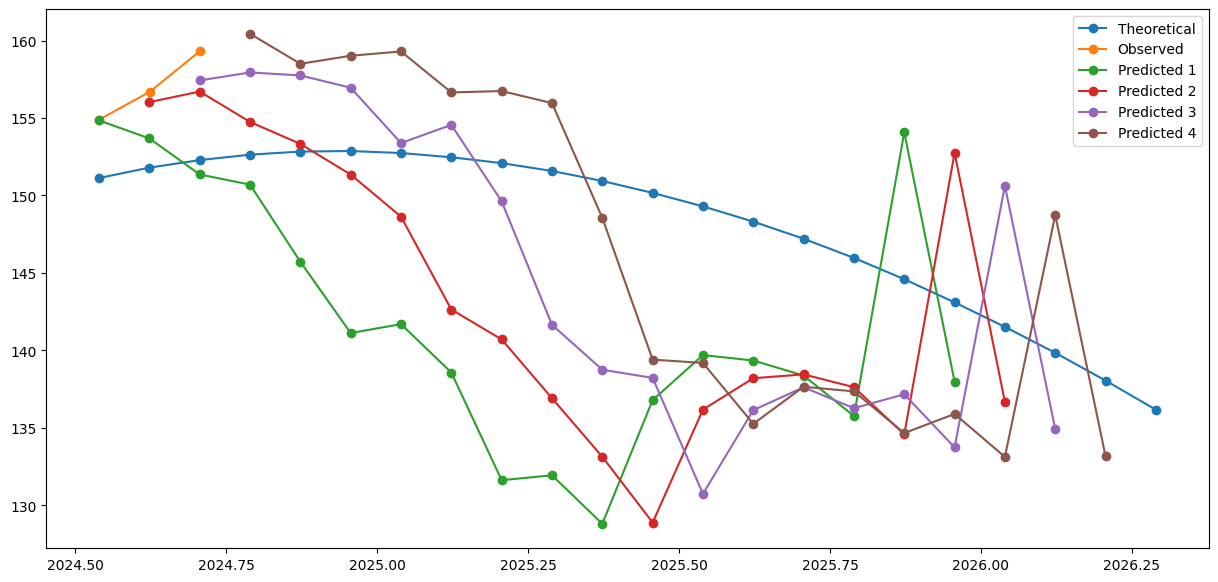

In [88]:
import seaborn as sns

plt.figure(figsize=(15, 7))
obs_n = len(observed_series)
first_date = df_ssn['Decimal Date'].iloc[obs_n - 4]

plt.plot(
    df_theoretical['decimal_date'][obs_n - 4:obs_n + 18],
    theoretical_series[obs_n - 4:obs_n + 18] * M,
    label='Theoretical',
    marker='o'
)
plt.plot(
    df_ssn['Decimal Date'][-4:-1],
    observed_series[-4:-1] * M,
    label='Observed',
    marker='o'
)

for i, pred in enumerate(predictions.T):
    plt.plot(
        df_theoretical['decimal_date'][obs_n - 4 + i:obs_n - 4 + i + 18],
        pred,
        label=f'Predicted {i+1}',
        marker='o'
    )

plt.legend()
plt.show()


In [71]:
df_theoretical['decimal_date'][obs_n:obs_n+18]

727    2024.873000
728    2024.956333
729    2025.039667
730    2025.123000
731    2025.206333
732    2025.289667
733    2025.373000
734    2025.456333
735    2025.539667
736    2025.623000
737    2025.706333
738    2025.789667
739    2025.873000
740    2025.956333
741    2026.039667
742    2026.123000
743    2026.206333
744    2026.289667
Name: decimal_date, dtype: float64

In [72]:
df_ssn['Decimal Date'][-4:-1]

723    2024.540
724    2024.624
725    2024.706
Name: Decimal Date, dtype: float64